In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot
import mapclassify
from IPython.display import HTML
from collections import Counter

### Load the census data

In [2]:
df_1910_census = pd.read_csv('data/1910_census_modern.csv', encoding='utf-8') # Generated from merge_data

In [6]:
df_1910_census.head()

,Municipality,Gender,Field of Work,Martial Status,Religion,Birth Year,Birth Place
0,Halden,Male,Vrft Skibstmmermand,Married,Norwegian Church,1837,Halden
1,Halden,Female,Housewife,Married,Norwegian Church,1839,Halden
2,Halden,Male,Sn,Single,Norwegian Church,1871,Halden
3,Halden,Female,Maid,Single,Norwegian Church,1894,Halden
4,Halden,Male,Vrft Skipstmmermand,Married,Norwegian Church,1884,Rakkestad


### Load the geo shape data

In [4]:
df_municipalities = gpd.read_file('shape/municipalities_2018.geojson')

In [5]:
# Get shape coordinates for drawing labels
df_municipalities['coords'] = df_municipalities['geometry'].apply(lambda x: x.representative_point().coords[:])
df_municipalities['coords'] = [coords[0] for coords in df_municipalities['coords']]

In [6]:
# Fix some municipalities, add a new column with fixed names so they work with census municip.

CONVERT = {
    # Municipality numbers -> fixed names
    '821':'Bø (Telemark)',
    '236':'Nes (Akershus)',
    '616':'Nes (Buskerud)',
    '137':'Våler (Østfold)',
    '426':'Våler (Innlandet)',
    '1867':'Bø (Nordland)',
    '441':'Os (Innlandet)',
    '1243':'Os (Hordaland)',
    '713':'Sande (Vestfold)',
    '1514':'Sande (Møre og Romsdal)',
    
    # Municipality names -> fixed names
    'Guovdageaidnu - Kautokeino':'Kautokeino - Guovdageainnu suohkan',
    'Kárásjohka - Karasjok':'Karasjok - Kárásjoga gielda',
    'Unjárga - Nesseby':'Nesseby - Unjárgga gielda',
    'Deatnu Tana':'Tana - Deanu gielda',
    'Porsanger - Porsángu - Porsanki':'Porsanger - Porsánjggu gielda - Porsangin komuuni',
    'Snåase - Snåsa':'Snåsa - Snåasen tjielte',
    'Fauske - Fuossko':'Fauske',
    'Loabák - Lavangen':'Lavangen',
    'Hamarøy - Hábmer':'Hamarøy',
    'Divtasvuodna - Tysfjord':'Hamarøy',
    'Storfjord - Omasvuotna - Omasvuo':'Lyngen',
    'Gáivuotna - Kåfjord - Kaivuono':'Lyngen',
    'Snillfjord':'Hitra',
    'Båtsfjord':'Vardø',
    'Fedje':'Austrheim',
    'Utsira':'Karmøy',
    'Rælingen':'Fet',
    'Sula':'Ålesund',
    'Midsund':'Aukra',
}

municipalityNamesUpdated = []
for n, m in zip(df_municipalities.loc[:,'Kommunenum'], df_municipalities.loc[:,'Kommunenav']):
    if str(n) in CONVERT:
        m = CONVERT[str(n)]
    elif str(m) in CONVERT:
        m = CONVERT[str(m)]
    municipalityNamesUpdated.append(m)

df_municipalities['Municipality'] = municipalityNamesUpdated

In [7]:
df_municipalities.head()

,Kommunenum,Kommunenav,geometry,coords,Municipality
0,2003,Vadsø,"MULTIPOLYGON (((1048559.000 7841160.000, 10485...","(1054011.9321760267, 7861141.75)",Vadsø
1,5020,Osen,"MULTIPOLYGON (((271292.990 7136757.000, 271212...","(289457.8256584622, 7137596.0)",Osen
2,1438,Bremanger,"MULTIPOLYGON (((-29156.720 6885495.170, -29225...","(-6423.51233544635, 6888777.095000001)",Bremanger
3,1244,Austevoll,"MULTIPOLYGON (((-54073.640 6689016.160, -54130...","(-47874.72859984809, 6691445.15)",Austevoll
4,1001,Kristiansand,"MULTIPOLYGON (((88111.860 6456544.010, 88145.8...","(86592.02205676393, 6470040.737160385)",Kristiansand


In [8]:
def visualize(data, values, title='', cat=False, figPath=None, dontShow=False):
    plt.rcParams['figure.figsize'] = (95, 30) # Fix figure size!
    
    if dontShow:
        plt.ioff()
    
    ax = data.plot(
        column=values, 
        cmap='Reds', 
        legend=True, 
        vmin=0.0, 
        vmax=(np.ceil(values[values.nonzero()].mean()) if (cat == False) else len(set(values))), 
        categorical=cat
    )
    
    # Draw municipality labels
    #for _, row in data.iterrows():
        #ax.annotate(s=row['Kommunenav'].upper(), xy=row['coords'], horizontalalignment='center', verticalalignment='center', color='green', alpha=0.95)
        
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False) 
    ax.set_title(title)
    
    if figPath:
        plt.savefig('img/{}.png'.format(figPath), transparent=False, bbox_inches='tight')
        
    if dontShow:
        plt.close()
        
def getPopulationPerMunicipality(census, municipalities):
    tmp = {}
    for k, v in Counter(census).most_common():
        tmp[k] = v
    return np.array([tmp[n] if n in tmp else 0 for n in municipalities])

def animatePopulationOverTime(year_start, year_end):
    years_of_interest = sorted([int(year) for year in set(df_1910_census.loc[:,'Birth Year']) if year is not '?' and int(year) >= year_start and int(year) <= year_end])
    temp = []
    
    for year in years_of_interest:
        people = df_1910_census.loc[df_1910_census.loc[:, 'Birth Year'] == str(year)]
        temp.append(getPopulationPerMunicipality(people.loc[:,'Municipality'], df_municipalities.loc[:,'Municipality']))
    
    for i, population in enumerate(np.cumsum(temp, axis=0)):
        year = years_of_interest[i]
        visualize(df_municipalities, population, '{}'.format(year), False, 'birth_{}'.format(year), True)
        print("Visualized", year, '!')


In [12]:
#visualize(df_municipalities, np.array([i for i in range(len(df_municipalities))]), 'TEST')
#visualize(df_municipalities, np.array([np.random.permutation(['YES', 'NO'])[0] for _ in range(len(df_municipalities))]), 'TEST', True)

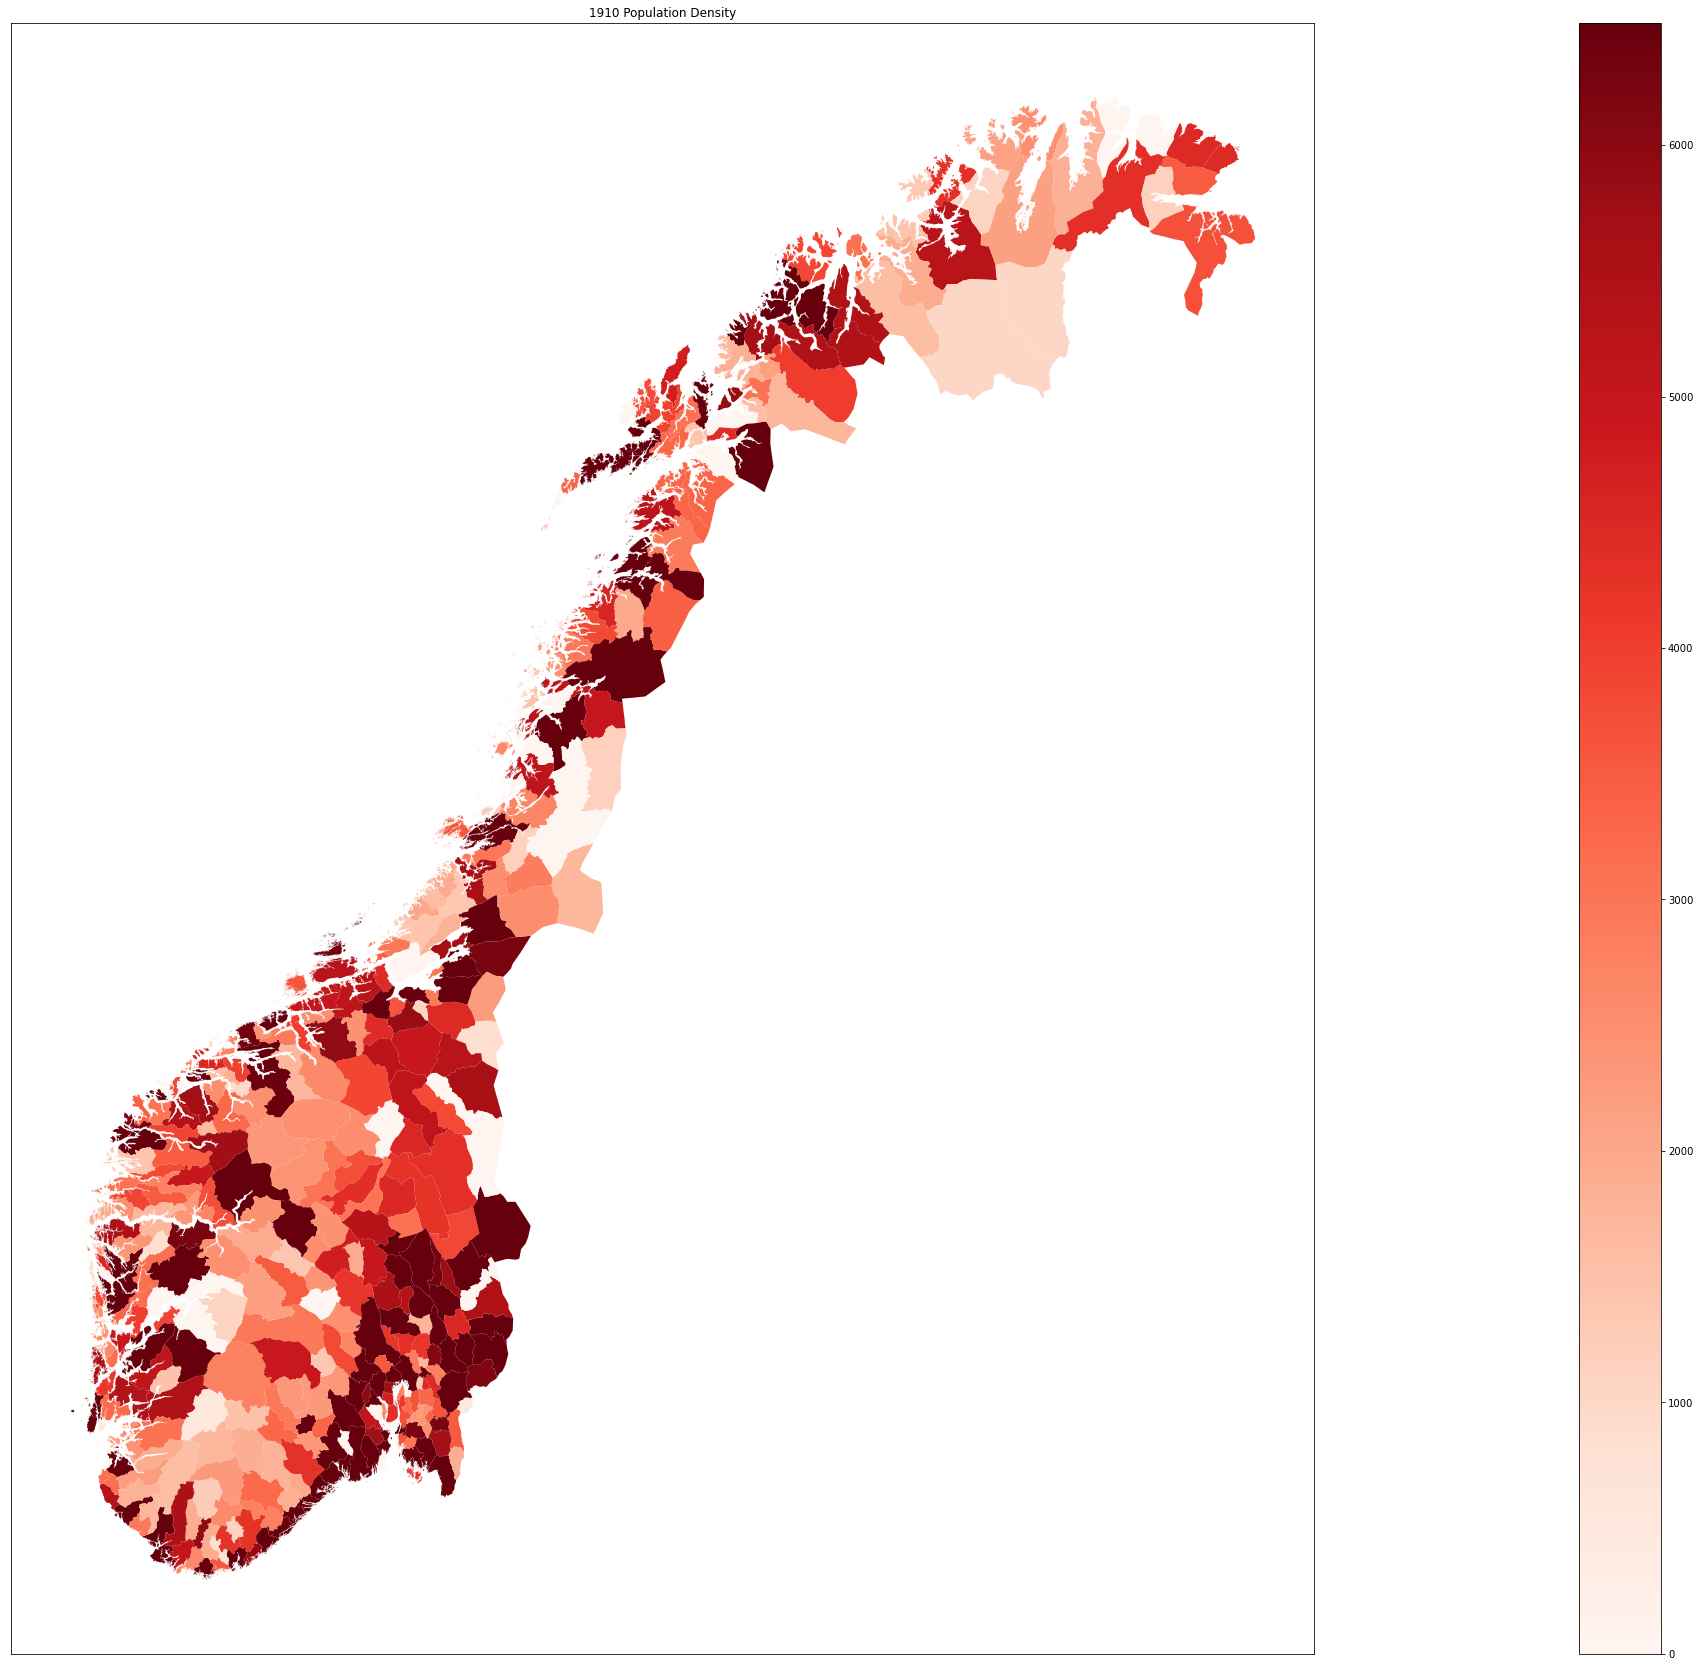

In [10]:
pop_1910 = getPopulationPerMunicipality(df_1910_census.loc[:,'Municipality'], df_municipalities.loc[:,'Municipality'])
visualize(df_municipalities, pop_1910, '1910 Population Density', False, '1910_img_test') # Density during 1910, roughly.

In [12]:
#animatePopulationOverTime(1800, 1900)

In [13]:
HTML('<img src="img/1800_1900_anim.gif">') # results!